In [214]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [215]:
sns.set(rc={'figure.figsize':(12,10.27)})

In [216]:
# importing datasets

df_17 = pd.read_csv('../../data/2017_JP_TS.csv', parse_dates=['DateTime'], index_col='DateTime')
df_18 = pd.read_csv('../../data/2018_JP_TS_Level4.csv', parse_dates=['DateTime'], index_col='DateTime')
df_19 = pd.read_csv('../../data/2019_JP_TS_Level4.csv', parse_dates=['DateTime'], index_col='DateTime')
df_20 = pd.read_csv('../../data/2020_JP_TS_Level4.csv', parse_dates=['DateTime'], index_col='DateTime')

df = pd.concat([df_17, df_18, df_19, df_20], axis=0)

df.rename(columns={'PC_Water_EXO':'pc'}, inplace=True)

In [217]:
n_lag = 23

In [218]:
df = df[~df['pc'].isna()]

In [219]:
cols_to_drop = list(filter(lambda x:x not in ('pc', 'DateTime'), df.columns))

In [220]:
df.drop(columns=cols_to_drop, inplace=True)

In [221]:
df['step'] = np.arange(len(df))

In [222]:
df['lag'] = df['pc'].shift(n_lag)

In [223]:
df.head()

,pc,step,lag
DateTime,,,
2019-03-20 15:00:00,0.512,0,NaN
2019-03-20 16:00:00,0.494,1,NaN
2019-03-20 17:00:00,0.477,2,NaN
2019-03-20 18:00:00,0.470,3,NaN
2019-03-20 19:00:00,0.462,4,NaN


In [224]:
filtered_df = df[~df['lag'].isna()]

In [225]:
filtered_df.head()

,pc,step,lag
DateTime,,,
2019-03-21 14:00:00,0.474,23,0.512
2019-03-21 15:00:00,0.473,24,0.494
2019-03-21 16:00:00,0.467,25,0.477
2019-03-21 17:00:00,0.486,26,0.470
2019-03-21 18:00:00,0.471,27,0.462


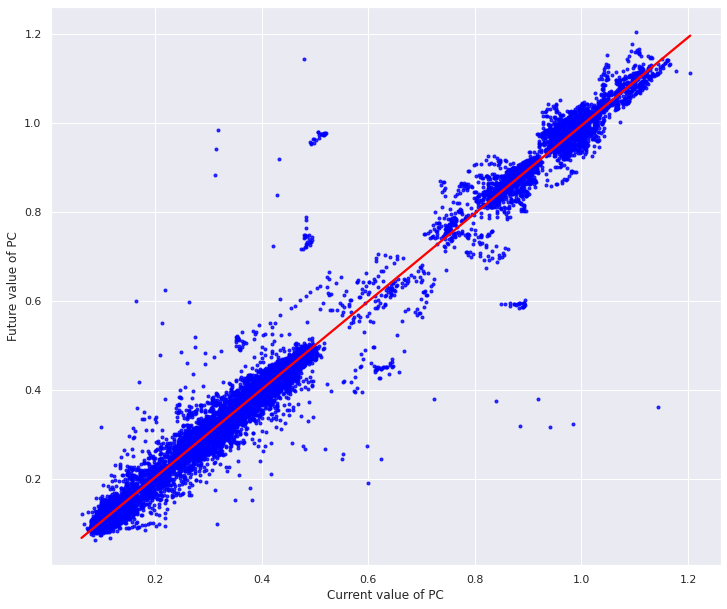

In [226]:
sns.regplot(x='lag', y='pc', data=filtered_df, color='blue', marker='.', label=f'Current vs. {n_lag} hours future', line_kws={'color':'red'}, order=1)
plt.xlabel('Current value of PC')
plt.ylabel('Future value of PC')
plt.show()

In [227]:
filtered_df['diff'] = filtered_df.pc - filtered_df.lag

/home/achara/achara_env/lib64/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [228]:
filtered_df.head()

,pc,step,lag,diff
DateTime,,,,
2019-03-21 14:00:00,0.474,23,0.512,-0.038
2019-03-21 15:00:00,0.473,24,0.494,-0.021
2019-03-21 16:00:00,0.467,25,0.477,-0.010
2019-03-21 17:00:00,0.486,26,0.470,0.016
2019-03-21 18:00:00,0.471,27,0.462,0.009


In [229]:
train_frac = 0.8
train_n = round(train_frac*len(filtered_df))
test_n = len(filtered_df) - train_n

train_df = filtered_df.iloc[:train_n, :]
test_df = filtered_df.iloc[train_n:,:]

In [230]:
# splitting the dataset:

X_train = train_df.loc[:,['step']]
y_train = train_df.loc[:,['diff']]

X_test = test_df.loc[:, ['step']]
y_test = test_df.loc[:, ['diff']]

In [231]:
from sklearn.linear_model import LinearRegression

In [232]:
regr = LinearRegression()


In [233]:
regr.fit(X_train, y_train)

LinearRegression()

In [234]:
y_pred = regr.predict(X_test)

In [235]:
residuals = y_pred - y_test

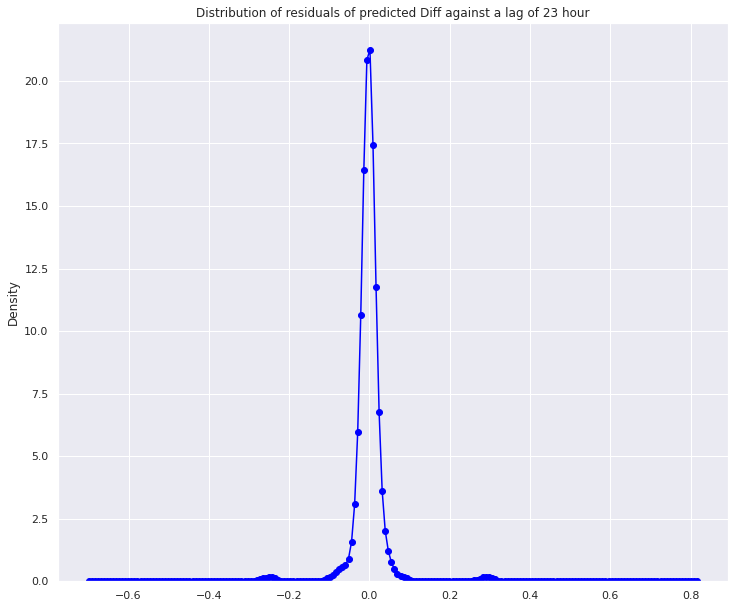

In [236]:
sns.kdeplot(np.reshape(residuals.values, (-1)), color='blue', marker='o')
plt.title(f'Distribution of residuals of predicted Diff against a lag of {n_lag} hour')
plt.show()

In [243]:
pc_pred=test_df.loc[:,['lag']]+y_pred

In [246]:
pc_pred.rename(columns={'lag':'pred_pc'}, inplace=True)

In [253]:
pc_pred['actual_pc'] = test_df.loc[:,['pc']]

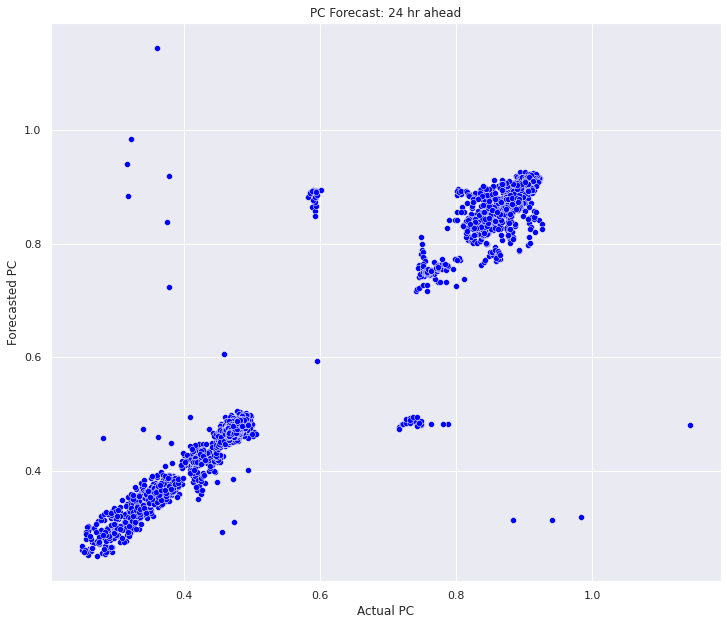

In [266]:
sns.scatterplot(x='actual_pc', y='pred_pc', data=pc_pred, color='blue', marker='o')
plt.xlabel('Actual PC')
plt.ylabel(f'Forecasted PC')
plt.title(f'PC Forecast: {n_lag+1} hr ahead')
plt.show()

In [260]:
residuals = pc_pred.pred_pc - pc_pred.actual_pc

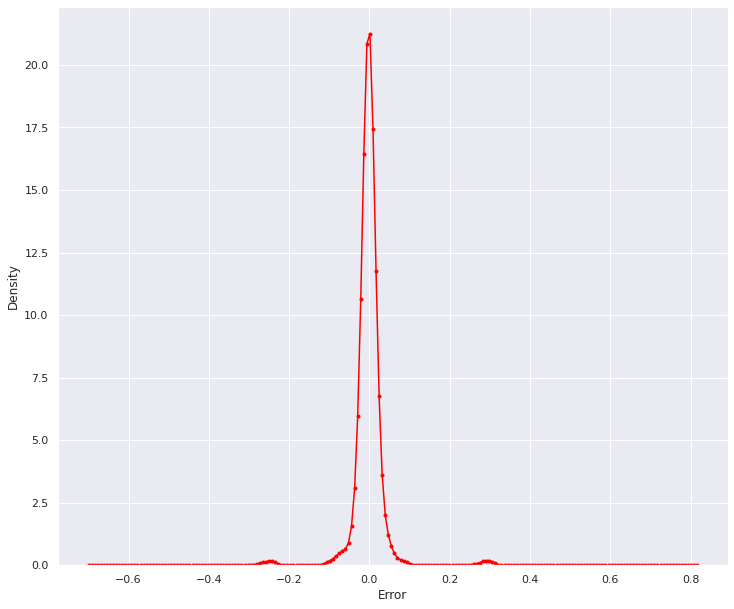

In [264]:
sns.kdeplot(residuals, color='red', marker='.')
plt.xlabel('Error')
plt.show()